In [10]:
import os
import random

data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN'
cls = [os.path.join(data_path, x) for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
cls

['/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog',
 '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree',
 '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2',
 '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess',
 '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank']

In [11]:
cls_files = {}

for x in cls:
    if x not in cls_files:
        cls_files[x] = [f for f in os.listdir(x) if os.path.isfile(os.path.join(x, f))]
        
cls_files

{'/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog': ['00000372.jpg',
  '00000414.jpg',
  '00000158.jpg',
  '00000164.jpg',
  '00000170.jpg',
  '00000366.png',
  '00000212.png',
  '00000206.jpg',
  '00000213.jpg',
  '00000367.png',
  '00000165.jpg',
  '00000159.jpg',
  '00000415.jpg',
  '00000198.png',
  '00000417.jpg',
  '00000365.jpg',
  '00000403.jpg',
  '00000173.jpg',
  '00000239.jpg',
  '00000210.jpg',
  '00000204.jpg',
  '00000238.jpg',
  '00000199.jpg',
  '00000166.jpg',
  '00000172.jpg',
  '00000416.jpg',
  '00000370.jpg',
  '00000358.jpg',
  '00000412.jpg',
  '00000406.jpg',
  '00000360.jpg',
  '00000348.jpg',
  '00000176.jpg',
  '00000162.jpg',
  '00000189.jpg',
  '00000228.png',
  '00000200.jpg',
  '00000214.jpg',
  '00000229.jpg',
  '00000215.jpg',
  '00000201.jpg',
  '00000349.png',
  '00000163.jpg',
  '00000177.jpg',
  '00000188.png',
  '00000361.jpg',
  '00000375.jpg',
  '00000377.jpg',
  '00000161.jpg',
  '00000175.jpg',
  '00000388.png',
  '00000203.png',
  

In [12]:
import random
import copy
import shutil

cls_val = {}
# 0.8, 0.2 비율로 기존의 TRAIN 셋을 나눠봅시다.
for x in cls:
    n_train_data = int(len(cls_files[x]) * 0.8) # train 비율 0.8
    n_val_data = len(cls_files[x]) - n_train_data # validation 비율 0.2
    print(len(cls_files[x]), n_train_data, n_val_data)
    train_data = random.sample(cls_files[x], n_train_data)
    val_data = copy.deepcopy(cls_files[x]) 
    
    for y in train_data: # TRAIN 폴더에서 VAL 폴더로 옮겨줄 데이터만 남기기
        val_data.remove(y)
        
    print(len(cls_files[x]), len(train_data), len(val_data))
    
    # 현재 클래스 디렉토리 생성
    x_cls = os.path.join('/Users/kenny_jung/aiffel/data/model-fit/data/VAL', x.split('/')[-1])
    os.makedirs(x_cls, exist_ok=True)
    for y in val_data:
        shutil.move(os.path.join(x, y), os.path.join(x_cls, y))
#         print(os.path.join(x, y), os.path.join(x_cls, y))

223 178 45
223 178 45
160 128 32
160 128 32
252 201 51
252 201 51
180 144 36
180 144 36
266 212 54
266 212 54


# Load Dataset

In [13]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label

# Defining Functions

In [14]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [15]:
def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)

In [16]:
def show_batch(image_batch, label_batch, class_names):
    '''
    데이터를 시각화해주는 함수
    '''
    size = len(image_batch)
    sub_size = size
    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.rc('font', size=10)
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        print(plt.title(class_names[label_batch[n]==True][0].title()))
        plt.title(label_batch[n].numpy().decode('utf-8'))
        plt.imshow(image_batch[n])
    plt.show()

In [17]:
def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

# train_dataset Loader

In [18]:
data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN' 
train_dataset = load_data(data_path, batch_size=6)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

Find 5 class : ['/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank']


Improper call to JPEG library in state 203
2024-04-08 11:26:55.999347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

# Pillow Verify

In [19]:
import glob
from PIL import Image

data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN'
extensions = ['.jpg', '.png', '.jpeg']

for i, img_path in enumerate(glob.glob(os.path.join(data_path, '*/*'))):
    try:
        img = Image.open(img_path)
        img.verify()
        print('Valid image')
    except Exception:
        print('Invalid image')

Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Vali

# Detecting Error while Decoding Image File

In [20]:
from struct import unpack
import tqdm


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for img in glob.glob(os.path.join(data_path, '*/*')):
    image = JPEG(img) 
    try:
        image.decode()   
    except:
        bads.append(img)

print(bads)

['/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000114.jpg', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000181.jpg']


In [21]:
for bad in bads:
    os.remove(bad)

# TRAIN/tree/00000114.jpg
# TRAIN/tree/00000181.jpg

In [22]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title().split('/')[-1])
        plt.imshow(image_batch[n])
    plt.show()
    

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

Find 5 class : ['/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess', '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank']


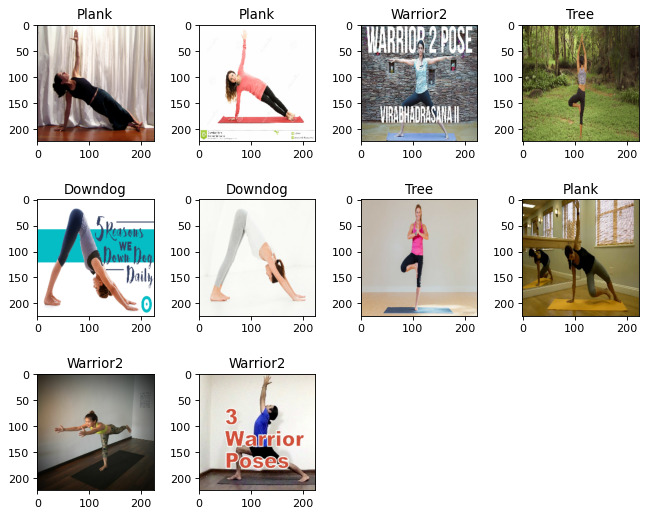

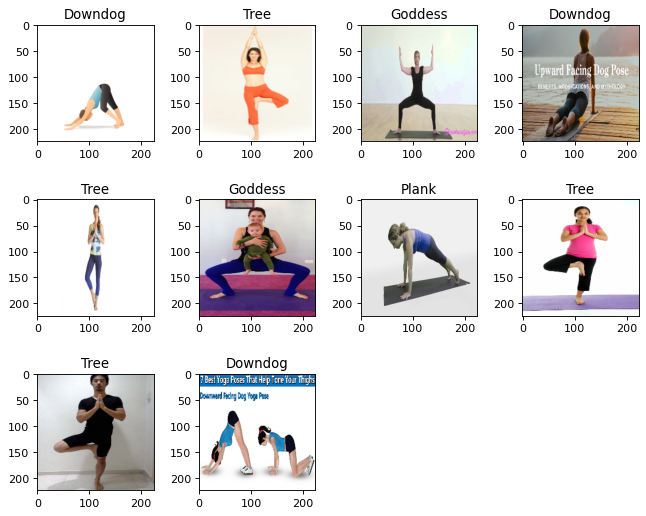

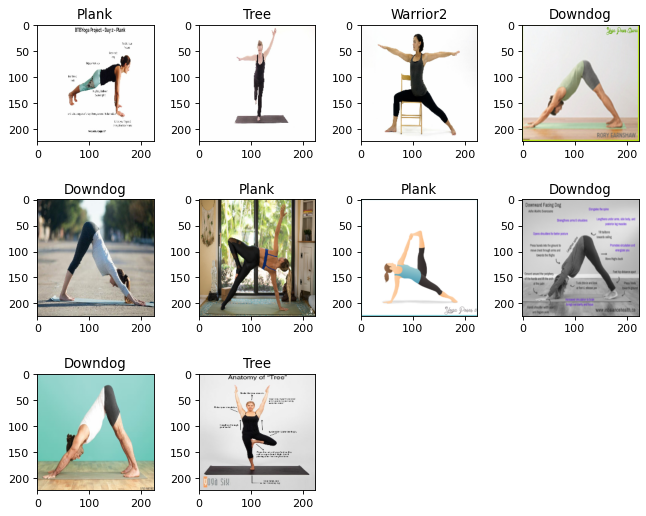

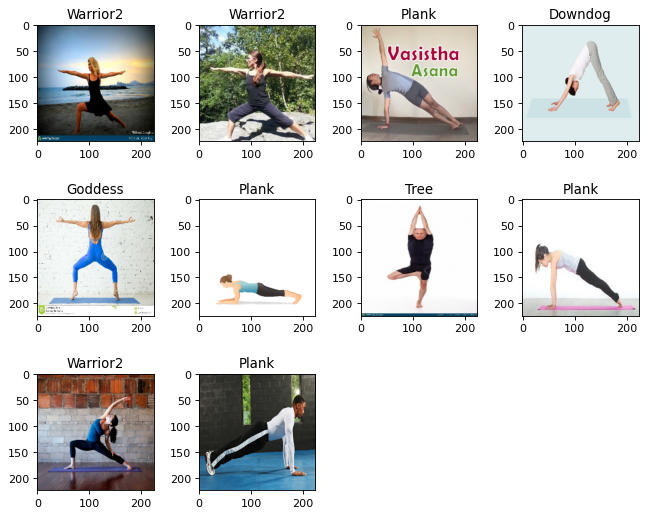

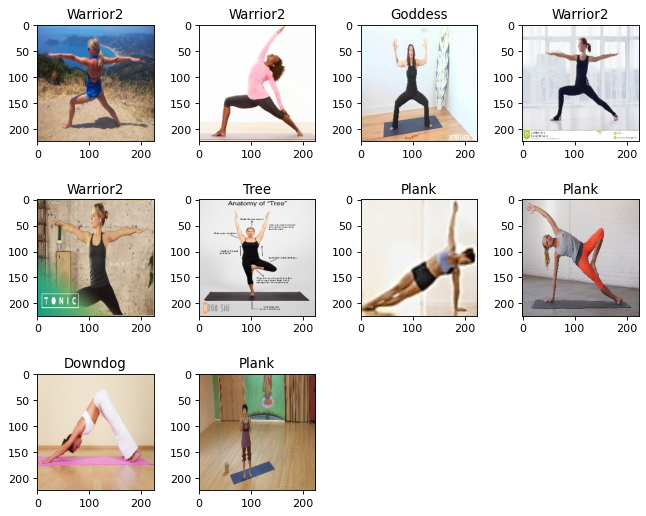

2024-04-08 11:27:06.425722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN'
train_dataset = load_data(data_path, batch_size=10)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

# Review Code

### tf.data.Dataset.list_files
data_dir의 하위의 모든 파일들을 가져오는 역할을 하는 함수

In [24]:
data_dir = '/Users/kenny_jung/aiffel/data/model-fit/data/TEST'
data_dir = pathlib.Path(data_path)

list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'))
for f in list_ds.take(5):
    print(f.numpy())

b'/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000367.jpg'
b'/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000306.jpg'
b'/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess/00000157.png'
b'/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000312.jpg'
b'/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000269.jpg'


2024-04-08 11:27:08.328949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### list_ds.map(lambda x: process_path(x, class_names))
데이터셋에 변환(transformation)을 적용

In [25]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep) # file path parse해서 라벨 얻기 
    label = label[-2] == class_names # 라벨 인코딩

    img = tf.io.read_file(file_path) # 이미지 읽기
    img = tf.image.decode_jpeg(img, channels=3) # 이미지 파일 디코딩
    img = tf.image.convert_image_dtype(img, tf.float32) # 이미지 타입 변환
    img = tf.image.resize(img, img_shape) # 이미지 사이즈 변환
    return img, label
    
labeled_ds = list_ds.map(lambda x: process_path(x, class_names))
labeled_ds

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.bool, name=None))>

### cache(), shuffle(), repeat(), batch(), prefetch() 함수
https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset


In [26]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, n_repeat=3):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat(n_repeat)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

# EfficientNet Modeling

https://arxiv.org/abs/1905.11946

https://keras.io/api/applications/efficientnet/

In [27]:
# !pip3 install tensorflow-estimator==2.6.0

In [28]:
from tensorflow.keras.applications import EfficientNetB0

class YogaPose(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 갯수 만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=5, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        if freeze:
            self.base_model.trainable = False
        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dropout(0.5, name="top_dropout")])
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")
    def call(self, inputs, training=True):
        x = self.base_model(inputs)
        x = self.top(x)
        x = self.classifier(x)
        return x

if __name__ == '__main__':
    model = YogaPose(num_classes=5, freeze=True)
    model.build(input_shape=(None, 224, 224, 3))
    print(model.summary())

/Users/kenny_jung/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'yoga_pose', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "yoga_pose"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

None


# Trainer

In [29]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # 매 batch 마다 반복적으로 학습
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # train metric 업데이트
                train_metric.update_state(y_batch_train, logits)
                # 5 배치마다 로깅
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # 마지막 epoch 학습이 끝나면 train 결과를 보여줌
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

### tf.GradientTape



In [30]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x**2
  
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()
# 출력 결과
# 6.0

6.0

In [31]:
epoch = 1
batch = 5
model = YogaPose(num_classes=5)
dataset = load_data(data_path=data_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                  epochs=epoch,
                  batch=batch,
                  loss_fn=loss_function,
                  optimizer=optimizer)

trainer.train(train_dataset=dataset,
              train_metric=train_acc_metric)


Start of epoch 0
Training loss (for one batch) at step 0: 1.6484
Seen so far: 5 samples
0.4
Training loss (for one batch) at step 5: 2.7727
Seen so far: 30 samples
0.36666667
Training loss (for one batch) at step 10: 0.3908
Seen so far: 55 samples
0.4
Training loss (for one batch) at step 15: 2.0404
Seen so far: 80 samples
0.3625
Training loss (for one batch) at step 20: 3.8773
Seen so far: 105 samples
0.4
Training loss (for one batch) at step 25: 0.9232
Seen so far: 130 samples
0.42307693


KeyboardInterrupt: 

# Progbar, Validation Data

### Progbar

In [32]:
def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

### Validation Data

In [ ]:
'''
dataset.py의 코드입니다! 
'''
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()

def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    print(class_names)
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

In [35]:
import math

train_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN'
val_path = '/Users/kenny_jung/aiffel/data/model-fit/data/VAL'
batch_size = 32

train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

print(TRAIN_SIZE, VAL_SIZE, steps_per_epoch, val_steps)

861 218 27 7


In [36]:
# train, val 데이터 셋 모두 (224, 224, 3) 사이즈의 input과 5개의 label에 대하여 true false로 이루어진 GT가 들어가있는지 확인합니다
train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.bool, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.bool, name=None))>)

### 그래프 생성, 연산 실행을 분리하여 속도를 더 빠르게 하고싶을 때는 @tf.fucnction 데코레이터

In [37]:
from tensorflow.keras.utils import Progbar

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [38]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - train_loss: 1.9644 - train_acc: 0.5000


2024-04-08 11:45:00.259670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: premature end of data segment


27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - train_loss: 1.9644 - train_acc: 0.5000 - val_loss: 1.7748 - val_acc: 0.2188


2024-04-08 11:45:05.811667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 2/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - train_loss: 1.8649 - train_acc: 0.6562


2024-04-08 11:45:42.281326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - train_loss: 1.8649 - train_acc: 0.6562 - val_loss: 1.6580 - val_acc: 0.4062


2024-04-08 11:45:47.219614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - train_loss: 1.4892 - train_acc: 0.7812


2024-04-08 11:46:23.881172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - train_loss: 1.4892 - train_acc: 0.7812 - val_loss: 1.6976 - val_acc: 0.1562


2024-04-08 11:46:28.530622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### tf.train.Checkpoint

In [43]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step, checkpoint_manager):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        best_loss = 100
        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
            
            if val_loss < best_loss:
                best_loss = val_loss
                print("\nSave better model")
                print(checkpoint_manager.save())

In [45]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory="/Users/kenny_jung/aiffel/data/model-fit/checkpoint", max_to_keep=5) #체크포인트 저장위치 자유롭게 변경

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric,
            checkpoint_manager=manager)


Epoch 1/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - train_loss: 1.7242 - train_acc: 0.5938


2024-04-08 11:50:43.530459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - train_loss: 1.7242 - train_acc: 0.5938 - val_loss: 1.5862 - val_acc: 0.2857


2024-04-08 11:50:47.895842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Save better model
/Users/kenny_jung/aiffel/data/model-fit/checkpoint/ckpt-1

Epoch 2/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - train_loss: 1.6529 - train_acc: 0.7188


2024-04-08 11:51:23.905055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - train_loss: 1.6529 - train_acc: 0.7188 - val_loss: 1.6622 - val_acc: 0.1562


2024-04-08 11:51:28.530614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - train_loss: 1.3502 - train_acc: 0.8125


2024-04-08 11:52:04.037172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - train_loss: 1.3502 - train_acc: 0.8125 - val_loss: 1.6053 - val_acc: 0.3125


2024-04-08 11:52:08.896208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# MoveNet (Coarse label로 custom dataloader)
https://www.tensorflow.org/hub/tutorials/movenet


In [46]:
# !pip install -q imageio
# !pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [51]:
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import cv2

# matplotlib 라이브러리 import
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# 이미지 display를 도와주는 imageio import
import imageio
from IPython.display import HTML, display

model_name = "movenet_lightning"

if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

In [52]:
def movenet(module, input_image):
    """Runs detection on an input image.
    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.
    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

### Load Dataset for Annotation

In [53]:
from pathlib import Path

# 데이터 셋 위치
data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
classes

[PosixPath('/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog'),
 PosixPath('/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree'),
 PosixPath('/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2'),
 PosixPath('/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess'),
 PosixPath('/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank')]

In [54]:
train_files = []
for cls in classes:
    train_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
train_files[:3], len(train_files)

(['/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000372.jpg',
  '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000158.jpg',
  '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000164.jpg'],
 861)

In [55]:
data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/VAL'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
val_files = []
for cls in classes:
    val_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
val_files[:3], len(val_files)

(['/Users/kenny_jung/aiffel/data/model-fit/data/VAL/downdog/00000414.jpg',
  '/Users/kenny_jung/aiffel/data/model-fit/data/VAL/downdog/00000417.jpg',
  '/Users/kenny_jung/aiffel/data/model-fit/data/VAL/downdog/00000365.jpg'],
 218)

In [56]:
data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TEST'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
test_files = []
for cls in classes:
    test_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
test_files[:3], len(test_files)

(['/Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000038.jpg',
  '/Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000004.jpg',
  '/Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000010.png'],
 470)

### Interence and export to Json

In [57]:
def get_keypoints(image, 
                  keypoints_with_scores,
                  output_image_height=None, 
                  keypoint_threshold=0.0):
    height, width, channel = image.shape
    aspect_ratio = float(width) / height

    keypoints_all = []
    num_instances,_,_,_ = keypoints_with_scores.shape
    for id in range(num_instances):
        kpts_x = keypoints_with_scores[0,id,:,1]
        kpts_y = keypoints_with_scores[0,id,:,0]
        kpts_scores = keypoints_with_scores[0,id,:,2]
        kpts_abs_xy = np.stack(
            [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
        kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
        keypoints_all.append(kpts_above_thrs_abs)

    return np.concatenate(keypoints_all,axis=0)

In [58]:
import json

def make_keypoints_json(files, module, input_size):
    keypoints = {}
    removed = []
    for image_path in files:
        # 이미지 에러에 대한 처리
        # 이미지가 tf.io.read_file로 읽을 수 없는 타입인 경우에 대비
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image)
        except:
            print('image error : ', image_path)
            removed.append(image_path)
            continue

        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

        # 모델 인퍼런스 에러에 대한 처리
        try:
            keypoints_with_scores = movenet(module, input_image)
            # print(keypoints_with_scores)
        except Exception as e:
#             print(input_image.shape)
            print('modl error : ', image_path)
            removed.append(image_path)
            continue

        keypoint_image = tf.expand_dims(image, axis=0)
        keypoint_image = tf.cast(tf.image.resize_with_pad(
            keypoint_image, 224, 224), dtype=tf.int32)
        output_overlay = get_keypoints(np.squeeze(keypoint_image.numpy(), axis=0), 
                                      keypoints_with_scores)
        # print(os.path.join('/'.join(image_path.split('/'))))
        keypoints.setdefault(os.path.join('/'.join(image_path.split('/'))), output_overlay.tolist())
        
    return keypoints, removed

In [59]:
train_keypoints, train_removed_files = make_keypoints_json(train_files, module, input_size)

2024-04-08 11:59:55.644420: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:55.644441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 11:59:55.688819: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:55.688837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000212.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000367.png


2024-04-08 11:59:56.270172: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:56.270188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 11:59:56.302239: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:56.302258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024

modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000349.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000188.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000388.png


2024-04-08 11:59:58.344741: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:58.344758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 11:59:58.370015: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:58.370033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000352.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000385.png


2024-04-08 11:59:58.680866: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:58.680884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 11:59:58.685167: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:58.685179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024

modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000351.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000345.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/downdog/00000379.png


2024-04-08 11:59:59.820283: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 11:59:59.820302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000200.png


2024-04-08 12:00:01.084751: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:01.084774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:01.208626: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:01.208643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000090.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000131.png


2024-04-08 12:00:01.971291: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:01.971308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000145.png


2024-04-08 12:00:02.659348: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:02.659369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:02.669786: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:02.669806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000154.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/tree/00000140.png


2024-04-08 12:00:03.318358: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:03.318383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000416.png


2024-04-08 12:00:04.029936: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:04.029956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000377.png


2024-04-08 12:00:04.678131: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 1 vs 3
2024-04-08 12:00:04.678151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000273.jpg


2024-04-08 12:00:05.186670: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:05.186691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:05.194564: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:05.194579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024

modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000287.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000250.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000331.png


2024-04-08 12:00:06.082098: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:06.082117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000123.png


2024-04-08 12:00:07.083293: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:07.083312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/warrior2/00000184.png


2024-04-08 12:00:08.951028: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:08.951047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess/00000272.png


2024-04-08 12:00:09.509502: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:09.509522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess/00000261.png


2024-04-08 12:00:09.897509: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:09.897527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess/00000127.png


2024-04-08 12:00:10.663369: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:10.663395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/goddess/00000193.png


2024-04-08 12:00:11.581637: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:11.581655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000170.png


2024-04-08 12:00:12.667784: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:12.667801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000388.png


2024-04-08 12:00:13.975066: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:13.975085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:14.083962: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:14.083983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000307.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000263.png


2024-04-08 12:00:14.497683: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:14.497700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000330.png


2024-04-08 12:00:14.794204: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:14.794231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000290.png


2024-04-08 12:00:15.150976: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:15.150999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000294.png


2024-04-08 12:00:15.497165: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:15.497183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:15.562163: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:15.562181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000136.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000179.png


2024-04-08 12:00:15.865605: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:15.865624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:16.008181: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:16.008199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000187.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000146.png


2024-04-08 12:00:16.955335: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:16.955353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TRAIN/plank/00000236.png


In [60]:
val_keypoints, val_removed_files = make_keypoints_json(val_files, module, input_size)

2024-04-08 12:00:42.643873: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:42.643892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:42.679271: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:42.679292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/VAL/downdog/00000287.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/VAL/downdog/00000245.png


2024-04-08 12:00:43.626786: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:43.626804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/VAL/tree/00000203.png


2024-04-08 12:00:44.170402: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:44.170421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/VAL/tree/00000157.png


2024-04-08 12:00:45.493499: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:45.493519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/VAL/warrior2/00000432.png


Corrupt JPEG data: premature end of data segment
2024-04-08 12:00:46.187196: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:46.187214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/VAL/goddess/00000282.png


2024-04-08 12:00:46.715909: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:46.715930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/VAL/plank/00000204.png


In [61]:
test_keypoints, test_removed_files = make_keypoints_json(test_files, module, input_size)

2024-04-08 12:00:57.021997: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:57.022016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000010.png


2024-04-08 12:00:57.264473: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:57.264491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000017.png


2024-04-08 12:00:57.796222: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:57.796241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:00:57.914413: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:57.914437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000075.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000102.png


2024-04-08 12:00:58.364236: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:58.364254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000127.png


2024-04-08 12:00:58.787865: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:00:58.787886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/downdog/00000041.png


2024-04-08 12:01:00.744473: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-04-08 12:01:01.012859: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:01.012878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:01:01.176748: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:01.176768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by f

modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/tree/00000047.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/tree/00000068.png


2024-04-08 12:01:01.398027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-04-08 12:01:01.668774: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:01.668798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/tree/00000019.png


2024-04-08 12:01:02.402459: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:02.402479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:01:02.551032: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:02.551050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/warrior2/00000039.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/warrior2/00000006.png


2024-04-08 12:01:03.323016: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:03.323072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/warrior2/00000115.png


2024-04-08 12:01:04.067727: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:04.067746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/warrior2/00000045.png


2024-04-08 12:01:04.819354: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:04.819372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/warrior2/00000025.png


2024-04-08 12:01:05.352657: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:05.352675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:01:05.505669: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:05.505691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/goddess/00000038.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/goddess/00000006.png


2024-04-08 12:01:06.285856: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-04-08 12:01:06.446661: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:06.446680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/goddess/00000092.png


2024-04-08 12:01:08.539163: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:08.539184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:01:08.661574: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:08.661592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/plank/00000058.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/plank/00000105.png


2024-04-08 12:01:08.985469: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:08.985489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:01:08.994840: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:08.994860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/plank/00000114.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/plank/00000116.png


2024-04-08 12:01:09.561009: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:09.561028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]
2024-04-08 12:01:09.574885: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:09.574905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/plank/00000079.png
modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/plank/00000050.png


2024-04-08 12:01:09.907297: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:764 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
2024-04-08 12:01:09.907319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]]


modl error :  /Users/kenny_jung/aiffel/data/model-fit/data/TEST/plank/00000054.png


In [63]:
# # train, val keypoints 합쳐서 한 번에 저장하기
train_keypoints.update(val_keypoints)
train_keypoints.keys()
with open("/Users/kenny_jung/aiffel/data/model-fit/keypoints_train_val.json", "w") as json_file:
    json.dump(train_keypoints, json_file)

# with open("/aiffel/aiffel/model-fit/keypoints_train_val.json", "r") as json_file:
#     keypoint_dict = json.load(json_file)
# keypoint_dict

In [64]:
# test keypoints 저장하기
with open("//Users/kenny_jung/aiffel/data/model-fitkeypoints_test.json", "w") as json_file:
    json.dump(test_keypoints, json_file)

In [65]:
# keypoints_train_val.json, keypoints_test.json이 제대로 생겼는지 확인
!ls /Users/kenny_jung/aiffel/data/model-fit

checkpoint               keypoints_test.json
data                     keypoints_train_val.json


In [66]:
def remove_files(removed):
    for file_path in removed:
        try:
            os.remove(file_path)
        except:
            print(file_path)

In [67]:
remove_files(train_removed_files)
remove_files(val_removed_files)
remove_files(test_removed_files)

# Dataloader for Image and Keypoints

In [71]:
keypoint = {}

def process_keypoint(file_path):
    global keypoint_dict
    file_path = file_path.numpy().decode('utf-8')
    file_path = os.path.join('./', file_path)
    keypoint = tf.convert_to_tensor(keypoint_dict[file_path], dtype=tf.float32)
    return keypoint

def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape) 

    [keypoint,] = tf.py_function(process_keypoint, [file_path], [tf.float32])

    return {"input_1": img, "input_2": keypoint}, label

def augment(inputs, label):
    image, keypoint = inputs['input_1'], inputs['input_2']
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.adjust_brightness(image, 0.4)
    image = tf.image.random_brightness(image, max_delta=0.4)
    return {'input_1' : image, 'input_2' : keypoint}, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, training=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    if training:
        ds = ds.map(lambda x, y: augment(x, y))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()


def load_data(data_path, img_shape=(224, 224), batch_size=32, training=True):
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    global keypoint_dict
    if training:
        with open("/Users/kenny_jung/aiffel/data/model-fit/keypoints_train_val.json", "r") as json_file:
            keypoint_dict = json.load(json_file)
    else:
        with open("/Users/kenny_jung/aiffel/data/model-fit/keypoints_test.json", "r") as json_file:
            keypoint_dict = json.load(json_file)

    return ds, DATASET_SIZE

In [72]:
# 내 데이터 위치
train_data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN'

train_ds, train_size = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=1)

for inputs in train_ds.take(1):
    print(inputs)

({'input_1': <tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[1.0032436 , 0.889518  , 0.87383175],
         [0.996871  , 0.88314545, 0.8674592 ],
         [1.0007925 , 0.8870671 , 0.8713808 ],
         ...,
         [1.0007925 , 0.8870671 , 0.8713808 ],
         [0.996871  , 0.88314545, 0.8674592 ],
         [1.0032436 , 0.889518  , 0.87383175]],

        [[0.9949101 , 0.8811847 , 0.8654984 ],
         [0.9904984 , 0.8767729 , 0.8610866 ],
         [0.99441993, 0.8806945 , 0.86500823],
         ...,
         [0.99441993, 0.8806945 , 0.86500823],
         [0.9904984 , 0.8767729 , 0.8610866 ],
         [0.9949101 , 0.8811847 , 0.8654984 ]],

        [[1.0007925 , 0.8870671 , 0.8713808 ],
         [0.99441993, 0.8806945 , 0.86500823],
         [0.99441993, 0.8806945 , 0.86500823],
         ...,
         [0.99441993, 0.8806945 , 0.86500823],
         [0.99441993, 0.8806945 , 0.86500823],
         [1.0007925 , 0.8870671 , 0.8713808 ]],

        ...,

        [[1.0007925 ,

2024-04-08 12:08:09.240252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Model for Multiple Inputs

In [73]:
from tensorflow.keras.applications import VGG16

class YogaPose(tf.keras.Model):
    def __init__(self, num_classes=30, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        self.keypoint = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(17, 2)),
                                              tf.keras.layers.Dense(34),])
        
        if freeze:
            self.base_model.trainable = False

        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.6, name="top_dropout")])
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")

    def call(self, inputs, training=True):
        image, keypoint = inputs['input_1'], inputs['input_2']
        x1 = self.base_model(image)
        x1 = self.top(x1)
        x2 = self.keypoint(keypoint)
        x = self.concat([x1, x2])
        x = self.classifier(x)
        return x

In [74]:
# 가짜 input
inputs = {'input_1':tf.ones([1, 224, 224, 3]), 'input_2':tf.ones([1, 17, 2])}
model = YogaPose(num_classes=2, freeze=True)
model(inputs)

/Users/kenny_jung/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.49066895, 0.50933105]], dtype=float32)>

In [75]:
from tensorflow.keras.utils import Progbar
import math

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

# Training Model

In [76]:
train_data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/TRAIN' 
val_data_path = '/Users/kenny_jung/aiffel/data/model-fit/data/VAL' 
batch_size = 16

train_ds, TRAIN_SIZE = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_data_path, img_shape=(224, 224), batch_size=batch_size)

In [77]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

In [78]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)  
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

# epoch을 조정해 보세요. 
trainer = Trainer(model=model,
                  epochs=100,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 52s 661ms/step - train_loss: 13.7934 - train_acc: 0.2500


2024-04-08 12:12:36.286105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: premature end of data segment


52/52 ━━━━━━━━━━━━━━━━━━━━ 59s 803ms/step - train_loss: 13.7934 - train_acc: 0.2500 - val_loss: 10.7362 - val_acc: 0.1875


2024-04-08 12:12:43.530842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 660ms/step - train_loss: 4.4797 - train_acc: 0.3750


2024-04-08 12:13:18.373123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 756ms/step - train_loss: 4.4797 - train_acc: 0.3750 - val_loss: 5.5946 - val_acc: 0.1875


2024-04-08 12:13:23.283392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 670ms/step - train_loss: 4.1295 - train_acc: 0.5625


2024-04-08 12:13:58.671194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 769ms/step - train_loss: 4.1295 - train_acc: 0.5625 - val_loss: 7.6478 - val_acc: 0.0625


2024-04-08 12:14:03.713190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 678ms/step - train_loss: 3.3898 - train_acc: 0.6250


2024-04-08 12:14:39.591080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 776ms/step - train_loss: 3.3898 - train_acc: 0.6250 - val_loss: 5.1171 - val_acc: 0.3125


2024-04-08 12:14:44.590565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 683ms/step - train_loss: 2.9122 - train_acc: 0.6250


2024-04-08 12:15:20.621046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 782ms/step - train_loss: 2.9122 - train_acc: 0.6250 - val_loss: 5.4506 - val_acc: 0.1875


2024-04-08 12:15:25.631970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 742ms/step - train_loss: 2.9242 - train_acc: 0.6875


2024-04-08 12:16:04.964347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 838ms/step - train_loss: 2.9242 - train_acc: 0.6875 - val_loss: 4.7517 - val_acc: 0.1875


2024-04-08 12:16:09.845411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - train_loss: 2.9025 - train_acc: 0.8125


2024-04-08 12:16:45.239618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 772ms/step - train_loss: 2.9025 - train_acc: 0.8125 - val_loss: 5.7280 - val_acc: 0.0625


2024-04-08 12:16:50.505097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 673ms/step - train_loss: 2.1233 - train_acc: 0.6250


2024-04-08 12:17:26.013144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 769ms/step - train_loss: 2.1233 - train_acc: 0.6250 - val_loss: 3.7548 - val_acc: 0.3750


2024-04-08 12:17:30.929990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - train_loss: 2.2789 - train_acc: 0.6875


2024-04-08 12:18:06.307999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 767ms/step - train_loss: 2.2789 - train_acc: 0.6875 - val_loss: 2.9723 - val_acc: 0.3750


2024-04-08 12:18:11.338268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 648ms/step - train_loss: 2.1658 - train_acc: 0.7500


2024-04-08 12:18:45.664165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 744ms/step - train_loss: 2.1658 - train_acc: 0.7500 - val_loss: 2.3569 - val_acc: 0.5625


2024-04-08 12:18:50.557547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 689ms/step - train_loss: 2.1611 - train_acc: 0.7500


2024-04-08 12:19:26.963606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 787ms/step - train_loss: 2.1611 - train_acc: 0.7500 - val_loss: 3.3618 - val_acc: 0.4375


2024-04-08 12:19:31.943805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 676ms/step - train_loss: 1.8226 - train_acc: 0.7500


2024-04-08 12:20:07.626196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 773ms/step - train_loss: 1.8226 - train_acc: 0.7500 - val_loss: 2.5526 - val_acc: 0.5000


2024-04-08 12:20:12.592909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 665ms/step - train_loss: 2.2293 - train_acc: 0.6875


2024-04-08 12:20:47.669876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - train_loss: 2.2293 - train_acc: 0.6875 - val_loss: 1.7029 - val_acc: 0.6250


2024-04-08 12:20:52.443862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 673ms/step - train_loss: 1.7334 - train_acc: 0.9375


2024-04-08 12:21:28.020370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 766ms/step - train_loss: 1.7334 - train_acc: 0.9375 - val_loss: 2.6607 - val_acc: 0.5000


2024-04-08 12:21:32.769466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 15/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 734ms/step - train_loss: 1.8296 - train_acc: 0.7500


2024-04-08 12:22:11.575721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 839ms/step - train_loss: 1.8296 - train_acc: 0.7500 - val_loss: 2.7730 - val_acc: 0.4375


2024-04-08 12:22:16.914390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 16/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 676ms/step - train_loss: 2.1461 - train_acc: 0.6250


2024-04-08 12:22:52.645337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 775ms/step - train_loss: 2.1461 - train_acc: 0.6250 - val_loss: 1.7001 - val_acc: 0.8125


2024-04-08 12:22:57.721539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 17/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 696ms/step - train_loss: 1.7914 - train_acc: 0.5625


2024-04-08 12:23:34.474233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 795ms/step - train_loss: 1.7914 - train_acc: 0.5625 - val_loss: 2.5733 - val_acc: 0.5625


2024-04-08 12:23:39.509688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 18/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - train_loss: 1.4634 - train_acc: 0.8750


2024-04-08 12:24:15.581897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 778ms/step - train_loss: 1.4634 - train_acc: 0.8750 - val_loss: 3.3490 - val_acc: 0.5625


2024-04-08 12:24:20.348125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 19/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 663ms/step - train_loss: 1.9012 - train_acc: 0.6875


2024-04-08 12:24:55.423296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 761ms/step - train_loss: 1.9012 - train_acc: 0.6875 - val_loss: 2.3925 - val_acc: 0.7500


2024-04-08 12:25:00.428441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 20/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 665ms/step - train_loss: 1.9003 - train_acc: 0.6875


2024-04-08 12:25:35.559729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 762ms/step - train_loss: 1.9003 - train_acc: 0.6875 - val_loss: 1.7820 - val_acc: 0.8125


2024-04-08 12:25:40.534787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 21/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 658ms/step - train_loss: 1.5691 - train_acc: 0.8125


2024-04-08 12:26:15.311305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 752ms/step - train_loss: 1.5691 - train_acc: 0.8125 - val_loss: 1.9873 - val_acc: 0.7500


2024-04-08 12:26:20.096165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 22/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 649ms/step - train_loss: 1.5674 - train_acc: 0.8750


2024-04-08 12:26:54.358060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 750ms/step - train_loss: 1.5674 - train_acc: 0.8750 - val_loss: 2.3970 - val_acc: 0.4375


2024-04-08 12:26:59.511964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 23/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - train_loss: 1.5935 - train_acc: 0.6875


2024-04-08 12:27:35.989567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 785ms/step - train_loss: 1.5935 - train_acc: 0.6875 - val_loss: 1.5391 - val_acc: 0.8750


2024-04-08 12:27:40.899207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 24/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - train_loss: 1.3577 - train_acc: 0.9375


2024-04-08 12:28:17.132447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 787ms/step - train_loss: 1.3577 - train_acc: 0.9375 - val_loss: 1.9522 - val_acc: 0.8125


2024-04-08 12:28:22.416016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 25/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 721ms/step - train_loss: 1.5268 - train_acc: 0.7500


2024-04-08 12:29:00.523320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 820ms/step - train_loss: 1.5268 - train_acc: 0.7500 - val_loss: 1.7283 - val_acc: 0.7500


2024-04-08 12:29:05.609284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 26/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 665ms/step - train_loss: 1.5024 - train_acc: 0.9375


2024-04-08 12:29:40.749693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 767ms/step - train_loss: 1.5024 - train_acc: 0.9375 - val_loss: 1.5775 - val_acc: 0.8125


2024-04-08 12:29:45.939005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 27/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - train_loss: 1.4174 - train_acc: 0.8750


2024-04-08 12:30:21.210969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 767ms/step - train_loss: 1.4174 - train_acc: 0.8750 - val_loss: 1.8665 - val_acc: 0.6875


2024-04-08 12:30:26.236250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 28/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - train_loss: 1.5117 - train_acc: 0.7500


2024-04-08 12:31:02.563589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 786ms/step - train_loss: 1.5117 - train_acc: 0.7500 - val_loss: 1.5651 - val_acc: 0.8125


2024-04-08 12:31:07.539773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 29/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - train_loss: 1.4845 - train_acc: 0.7500


2024-04-08 12:31:42.928574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 765ms/step - train_loss: 1.4845 - train_acc: 0.7500 - val_loss: 1.4436 - val_acc: 0.8125


2024-04-08 12:31:47.891169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 30/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 675ms/step - train_loss: 1.4524 - train_acc: 0.8750


2024-04-08 12:32:23.536711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 776ms/step - train_loss: 1.4524 - train_acc: 0.8750 - val_loss: 1.5313 - val_acc: 0.8125


2024-04-08 12:32:28.662999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 31/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 694ms/step - train_loss: 1.7601 - train_acc: 0.7500


2024-04-08 12:33:05.327484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 792ms/step - train_loss: 1.7601 - train_acc: 0.7500 - val_loss: 1.4810 - val_acc: 0.7500


2024-04-08 12:33:10.302570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 32/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 691ms/step - train_loss: 1.5774 - train_acc: 0.7500


2024-04-08 12:33:46.776785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 787ms/step - train_loss: 1.5774 - train_acc: 0.7500 - val_loss: 2.0864 - val_acc: 0.8125


2024-04-08 12:33:51.675743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 33/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - train_loss: 1.4559 - train_acc: 0.8125


2024-04-08 12:34:28.081044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 789ms/step - train_loss: 1.4559 - train_acc: 0.8125 - val_loss: 1.6256 - val_acc: 0.8125


2024-04-08 12:34:33.263969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 34/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - train_loss: 1.4217 - train_acc: 0.9375


2024-04-08 12:35:09.127542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 787ms/step - train_loss: 1.4217 - train_acc: 0.9375 - val_loss: 2.3506 - val_acc: 0.5625


2024-04-08 12:35:14.580465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 35/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - train_loss: 1.4162 - train_acc: 0.8750


2024-04-08 12:35:50.769623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 785ms/step - train_loss: 1.4162 - train_acc: 0.8750 - val_loss: 1.7486 - val_acc: 0.6875


2024-04-08 12:35:55.870091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 36/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 711ms/step - train_loss: 1.3969 - train_acc: 0.9375


2024-04-08 12:36:33.385838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 810ms/step - train_loss: 1.3969 - train_acc: 0.9375 - val_loss: 1.7601 - val_acc: 0.8125


2024-04-08 12:36:38.456437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 37/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 708ms/step - train_loss: 1.5888 - train_acc: 1.0000


2024-04-08 12:37:15.793900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 807ms/step - train_loss: 1.5888 - train_acc: 1.0000 - val_loss: 2.2298 - val_acc: 0.7500


2024-04-08 12:37:20.812415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 38/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 696ms/step - train_loss: 1.4079 - train_acc: 0.9375


2024-04-08 12:37:57.524918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 795ms/step - train_loss: 1.4079 - train_acc: 0.9375 - val_loss: 1.2438 - val_acc: 0.8750


2024-04-08 12:38:02.550600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 39/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 669ms/step - train_loss: 1.4788 - train_acc: 0.8750


2024-04-08 12:38:38.056436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 770ms/step - train_loss: 1.4788 - train_acc: 0.8750 - val_loss: 1.4267 - val_acc: 0.8125


2024-04-08 12:38:43.171830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 40/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 770ms/step - train_loss: 1.3843 - train_acc: 0.8125


2024-04-08 12:39:23.812980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 46s 876ms/step - train_loss: 1.3843 - train_acc: 0.8125 - val_loss: 1.6347 - val_acc: 0.6875


2024-04-08 12:39:29.210422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 41/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 711ms/step - train_loss: 1.2396 - train_acc: 0.8750


2024-04-08 12:40:06.730814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 809ms/step - train_loss: 1.2396 - train_acc: 0.8750 - val_loss: 1.3481 - val_acc: 0.7500


2024-04-08 12:40:11.739565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 42/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - train_loss: 1.3588 - train_acc: 0.7500


2024-04-08 12:40:47.829570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 783ms/step - train_loss: 1.3588 - train_acc: 0.7500 - val_loss: 1.2439 - val_acc: 0.9375


2024-04-08 12:40:52.841521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 43/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 691ms/step - train_loss: 1.2977 - train_acc: 0.9375


2024-04-08 12:41:29.509953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 794ms/step - train_loss: 1.2977 - train_acc: 0.9375 - val_loss: 2.3317 - val_acc: 0.6250


2024-04-08 12:41:34.728597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 687ms/step - train_loss: 1.5174 - train_acc: 0.8125


2024-04-08 12:42:10.973660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 789ms/step - train_loss: 1.5174 - train_acc: 0.8125 - val_loss: 1.3894 - val_acc: 0.8125


2024-04-08 12:42:16.182967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 702ms/step - train_loss: 1.4311 - train_acc: 0.9375


2024-04-08 12:42:53.344199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 801ms/step - train_loss: 1.4311 - train_acc: 0.9375 - val_loss: 1.3026 - val_acc: 0.8125


2024-04-08 12:42:58.436090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 673ms/step - train_loss: 1.2863 - train_acc: 0.9375


2024-04-08 12:43:33.951933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 768ms/step - train_loss: 1.2863 - train_acc: 0.9375 - val_loss: 1.2611 - val_acc: 0.9375


2024-04-08 12:43:38.794280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 676ms/step - train_loss: 1.5205 - train_acc: 0.6250


2024-04-08 12:44:14.512782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 775ms/step - train_loss: 1.5205 - train_acc: 0.6250 - val_loss: 1.9500 - val_acc: 0.6250


2024-04-08 12:44:19.538807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 696ms/step - train_loss: 1.6123 - train_acc: 0.8125


2024-04-08 12:44:56.419731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 794ms/step - train_loss: 1.6123 - train_acc: 0.8125 - val_loss: 1.3111 - val_acc: 0.8750


2024-04-08 12:45:01.386155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 693ms/step - train_loss: 1.4702 - train_acc: 0.6875


2024-04-08 12:45:38.019176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 791ms/step - train_loss: 1.4702 - train_acc: 0.6875 - val_loss: 1.3499 - val_acc: 0.9375


2024-04-08 12:45:43.005457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 50/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 726ms/step - train_loss: 1.2489 - train_acc: 0.8750


2024-04-08 12:46:21.144744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 820ms/step - train_loss: 1.2489 - train_acc: 0.8750 - val_loss: 1.3470 - val_acc: 0.8125


2024-04-08 12:46:25.974149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 51/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 692ms/step - train_loss: 1.3057 - train_acc: 0.9375


2024-04-08 12:47:02.490753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 784ms/step - train_loss: 1.3057 - train_acc: 0.9375 - val_loss: 1.1665 - val_acc: 0.9375


2024-04-08 12:47:07.208238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 52/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 696ms/step - train_loss: 1.2804 - train_acc: 0.8750


2024-04-08 12:47:43.896750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 794ms/step - train_loss: 1.2804 - train_acc: 0.8750 - val_loss: 1.5160 - val_acc: 0.8125


2024-04-08 12:47:48.934335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 53/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 671ms/step - train_loss: 1.2412 - train_acc: 0.9375


2024-04-08 12:48:24.307193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 769ms/step - train_loss: 1.2412 - train_acc: 0.9375 - val_loss: 1.7550 - val_acc: 0.6250


2024-04-08 12:48:29.311786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 54/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 652ms/step - train_loss: 1.3270 - train_acc: 0.8125


2024-04-08 12:49:03.717373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 747ms/step - train_loss: 1.3270 - train_acc: 0.8125 - val_loss: 1.3154 - val_acc: 0.8750


2024-04-08 12:49:08.533070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 55/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 692ms/step - train_loss: 1.6362 - train_acc: 0.6875


2024-04-08 12:49:45.056359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 792ms/step - train_loss: 1.6362 - train_acc: 0.6875 - val_loss: 1.5249 - val_acc: 0.6875


2024-04-08 12:49:50.140819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 56/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - train_loss: 1.2141 - train_acc: 0.8750


2024-04-08 12:50:26.320550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 788ms/step - train_loss: 1.2141 - train_acc: 0.8750 - val_loss: 1.1515 - val_acc: 0.8125


2024-04-08 12:50:31.496011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 57/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 722ms/step - train_loss: 1.1654 - train_acc: 0.8750


2024-04-08 12:51:09.516387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 822ms/step - train_loss: 1.1654 - train_acc: 0.8750 - val_loss: 1.5731 - val_acc: 0.7500


2024-04-08 12:51:14.613152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 58/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 710ms/step - train_loss: 1.3691 - train_acc: 0.8125


2024-04-08 12:51:52.029302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 811ms/step - train_loss: 1.3691 - train_acc: 0.8125 - val_loss: 1.6435 - val_acc: 0.7500


2024-04-08 12:51:57.169606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 59/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 642ms/step - train_loss: 1.1547 - train_acc: 1.0000


2024-04-08 12:52:31.230149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 736ms/step - train_loss: 1.1547 - train_acc: 1.0000 - val_loss: 1.2894 - val_acc: 0.7500


2024-04-08 12:52:35.998313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 60/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 657ms/step - train_loss: 1.3656 - train_acc: 0.8125


2024-04-08 12:53:10.708052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 748ms/step - train_loss: 1.3656 - train_acc: 0.8125 - val_loss: 1.4679 - val_acc: 0.8125


2024-04-08 12:53:15.338273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 61/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 681ms/step - train_loss: 1.2930 - train_acc: 0.8750


2024-04-08 12:53:51.273991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 775ms/step - train_loss: 1.2930 - train_acc: 0.8750 - val_loss: 1.0781 - val_acc: 1.0000


2024-04-08 12:53:56.078576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 62/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 638ms/step - train_loss: 1.4334 - train_acc: 0.7500


2024-04-08 12:54:29.892906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 724ms/step - train_loss: 1.4334 - train_acc: 0.7500 - val_loss: 1.5219 - val_acc: 0.6875


2024-04-08 12:54:34.288558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 63/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 625ms/step - train_loss: 1.5361 - train_acc: 0.6875


2024-04-08 12:55:07.268538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 716ms/step - train_loss: 1.5361 - train_acc: 0.6875 - val_loss: 1.7100 - val_acc: 0.6875


2024-04-08 12:55:11.943333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 64/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 634ms/step - train_loss: 1.1217 - train_acc: 1.0000


2024-04-08 12:55:45.443247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 727ms/step - train_loss: 1.1217 - train_acc: 1.0000 - val_loss: 1.4622 - val_acc: 0.6875


2024-04-08 12:55:50.203693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 65/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 638ms/step - train_loss: 1.1278 - train_acc: 1.0000


2024-04-08 12:56:23.845711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 728ms/step - train_loss: 1.1278 - train_acc: 1.0000 - val_loss: 1.3569 - val_acc: 0.8125


2024-04-08 12:56:28.426226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 66/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 626ms/step - train_loss: 1.1169 - train_acc: 0.9375


2024-04-08 12:57:01.513555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 716ms/step - train_loss: 1.1169 - train_acc: 0.9375 - val_loss: 1.1719 - val_acc: 0.8750


2024-04-08 12:57:06.091330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 67/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - train_loss: 1.3321 - train_acc: 0.8125


2024-04-08 12:57:39.876064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 728ms/step - train_loss: 1.3321 - train_acc: 0.8125 - val_loss: 2.1548 - val_acc: 0.6875


2024-04-08 12:57:44.433634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 68/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 634ms/step - train_loss: 1.2469 - train_acc: 0.8750


2024-04-08 12:58:17.933859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 722ms/step - train_loss: 1.2469 - train_acc: 0.8750 - val_loss: 1.3080 - val_acc: 0.8750


2024-04-08 12:58:22.453557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 69/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - train_loss: 1.2432 - train_acc: 0.8125


2024-04-08 12:58:56.049276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 725ms/step - train_loss: 1.2432 - train_acc: 0.8125 - val_loss: 1.2590 - val_acc: 0.7500


2024-04-08 12:59:00.623129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 70/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 632ms/step - train_loss: 1.1784 - train_acc: 1.0000


2024-04-08 12:59:34.006232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 721ms/step - train_loss: 1.1784 - train_acc: 1.0000 - val_loss: 1.0805 - val_acc: 0.8750


2024-04-08 12:59:38.560571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 71/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 633ms/step - train_loss: 1.1050 - train_acc: 1.0000


2024-04-08 13:00:11.996441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 723ms/step - train_loss: 1.1050 - train_acc: 1.0000 - val_loss: 1.3537 - val_acc: 0.7500


2024-04-08 13:00:16.596448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 72/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - train_loss: 1.1186 - train_acc: 1.0000


2024-04-08 13:00:49.892436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 721ms/step - train_loss: 1.1186 - train_acc: 1.0000 - val_loss: 1.2203 - val_acc: 0.8125


2024-04-08 13:00:54.563862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 73/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 674ms/step - train_loss: 1.1703 - train_acc: 0.9375


2024-04-08 13:01:30.178013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 763ms/step - train_loss: 1.1703 - train_acc: 0.9375 - val_loss: 1.3343 - val_acc: 0.8125


2024-04-08 13:01:34.718024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 74/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - train_loss: 1.2891 - train_acc: 0.8750


2024-04-08 13:02:08.269241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 725ms/step - train_loss: 1.2891 - train_acc: 0.8750 - val_loss: 1.2766 - val_acc: 0.6875


2024-04-08 13:02:12.870820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 75/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 638ms/step - train_loss: 1.1147 - train_acc: 0.9375


2024-04-08 13:02:46.609406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 731ms/step - train_loss: 1.1147 - train_acc: 0.9375 - val_loss: 1.0648 - val_acc: 0.9375


2024-04-08 13:02:51.347421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 76/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 642ms/step - train_loss: 1.0062 - train_acc: 1.0000


2024-04-08 13:03:25.214078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 736ms/step - train_loss: 1.0062 - train_acc: 1.0000 - val_loss: 1.5321 - val_acc: 0.8125


2024-04-08 13:03:29.990476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 77/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - train_loss: 1.0886 - train_acc: 1.0000


2024-04-08 13:04:03.509226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 725ms/step - train_loss: 1.0886 - train_acc: 1.0000 - val_loss: 1.3406 - val_acc: 0.8125


2024-04-08 13:04:08.103822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 78/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 640ms/step - train_loss: 1.1159 - train_acc: 0.8750


2024-04-08 13:04:41.945071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 733ms/step - train_loss: 1.1159 - train_acc: 0.8750 - val_loss: 1.4059 - val_acc: 0.8750


2024-04-08 13:04:46.685870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 79/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - train_loss: 1.1138 - train_acc: 0.8750


2024-04-08 13:05:20.440367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 727ms/step - train_loss: 1.1138 - train_acc: 0.8750 - val_loss: 1.1148 - val_acc: 0.9375


2024-04-08 13:05:24.921198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 80/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - train_loss: 1.1002 - train_acc: 1.0000


2024-04-08 13:05:57.523076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 701ms/step - train_loss: 1.1002 - train_acc: 1.0000 - val_loss: 1.4643 - val_acc: 0.6250


2024-04-08 13:06:01.901188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 81/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - train_loss: 1.2262 - train_acc: 1.0000


2024-04-08 13:06:33.558382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 683ms/step - train_loss: 1.2262 - train_acc: 1.0000 - val_loss: 1.3586 - val_acc: 0.6875


2024-04-08 13:06:37.855365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 82/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - train_loss: 1.2980 - train_acc: 0.7500


2024-04-08 13:07:09.456267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 682ms/step - train_loss: 1.2980 - train_acc: 0.7500 - val_loss: 1.3447 - val_acc: 0.5625


2024-04-08 13:07:13.808532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 83/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 632ms/step - train_loss: 1.4438 - train_acc: 0.6875


2024-04-08 13:07:47.121733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 720ms/step - train_loss: 1.4438 - train_acc: 0.6875 - val_loss: 1.2065 - val_acc: 0.9375


2024-04-08 13:07:51.605622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 84/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - train_loss: 1.1477 - train_acc: 0.9375


2024-04-08 13:08:23.340218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - train_loss: 1.1477 - train_acc: 0.9375 - val_loss: 1.0443 - val_acc: 1.0000


2024-04-08 13:08:27.758847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 85/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - train_loss: 1.1539 - train_acc: 0.8750


2024-04-08 13:08:59.932968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 696ms/step - train_loss: 1.1539 - train_acc: 0.8750 - val_loss: 1.0406 - val_acc: 0.9375


2024-04-08 13:09:04.340171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - train_loss: 1.1850 - train_acc: 0.8750


2024-04-08 13:09:36.612095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 698ms/step - train_loss: 1.1850 - train_acc: 0.8750 - val_loss: 1.4807 - val_acc: 0.8125


2024-04-08 13:09:41.036147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 606ms/step - train_loss: 1.1129 - train_acc: 0.8750


2024-04-08 13:10:13.093260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 692ms/step - train_loss: 1.1129 - train_acc: 0.8750 - val_loss: 1.2904 - val_acc: 0.8125


2024-04-08 13:10:17.460963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 609ms/step - train_loss: 1.0842 - train_acc: 1.0000


2024-04-08 13:10:49.677718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 694ms/step - train_loss: 1.0842 - train_acc: 1.0000 - val_loss: 1.5422 - val_acc: 0.6875


2024-04-08 13:10:54.044805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - train_loss: 1.0724 - train_acc: 0.8750


2024-04-08 13:11:25.903074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 687ms/step - train_loss: 1.0724 - train_acc: 0.8750 - val_loss: 1.2233 - val_acc: 0.8125


2024-04-08 13:11:30.251261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step - train_loss: 1.0892 - train_acc: 0.9375


2024-04-08 13:12:01.608297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 678ms/step - train_loss: 1.0892 - train_acc: 0.9375 - val_loss: 1.8083 - val_acc: 0.6250


2024-04-08 13:12:05.940324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - train_loss: 1.1355 - train_acc: 1.0000


2024-04-08 13:12:37.573398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 683ms/step - train_loss: 1.1355 - train_acc: 1.0000 - val_loss: 1.1657 - val_acc: 0.9375


2024-04-08 13:12:41.945967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 92/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 606ms/step - train_loss: 1.0225 - train_acc: 1.0000


2024-04-08 13:13:14.030164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 692ms/step - train_loss: 1.0225 - train_acc: 1.0000 - val_loss: 1.0207 - val_acc: 1.0000


2024-04-08 13:13:18.404522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 93/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - train_loss: 1.0587 - train_acc: 1.0000


2024-04-08 13:13:50.599322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 700ms/step - train_loss: 1.0587 - train_acc: 1.0000 - val_loss: 1.5228 - val_acc: 0.7500


2024-04-08 13:13:55.182250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 94/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - train_loss: 1.1011 - train_acc: 0.9375


2024-04-08 13:14:28.523629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 716ms/step - train_loss: 1.1011 - train_acc: 0.9375 - val_loss: 1.3491 - val_acc: 0.7500


2024-04-08 13:14:32.917106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 95/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - train_loss: 1.1100 - train_acc: 0.9375


2024-04-08 13:15:04.631485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - train_loss: 1.1100 - train_acc: 0.9375 - val_loss: 1.0837 - val_acc: 0.9375


2024-04-08 13:15:09.056095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 96/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - train_loss: 1.0561 - train_acc: 1.0000


2024-04-08 13:15:40.566007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - train_loss: 1.0561 - train_acc: 1.0000 - val_loss: 1.5434 - val_acc: 0.6250


2024-04-08 13:15:44.860940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 97/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 596ms/step - train_loss: 1.1667 - train_acc: 0.8750


2024-04-08 13:16:16.351322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - train_loss: 1.1667 - train_acc: 0.8750 - val_loss: 1.0525 - val_acc: 1.0000


2024-04-08 13:16:20.636040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 98/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 593ms/step - train_loss: 1.1103 - train_acc: 0.9375


2024-04-08 13:16:51.999938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 678ms/step - train_loss: 1.1103 - train_acc: 0.9375 - val_loss: 1.2202 - val_acc: 0.8125


2024-04-08 13:16:56.337189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 99/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - train_loss: 1.0792 - train_acc: 0.9375


2024-04-08 13:17:27.849435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - train_loss: 1.0792 - train_acc: 0.9375 - val_loss: 1.8526 - val_acc: 0.7500


2024-04-08 13:17:32.158288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 100/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 605ms/step - train_loss: 1.0643 - train_acc: 1.0000


2024-04-08 13:18:04.128770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 692ms/step - train_loss: 1.0643 - train_acc: 1.0000 - val_loss: 1.2392 - val_acc: 0.8125


2024-04-08 13:18:08.536651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [79]:
num_classes = 1 
epoch = 1 
batch_size = 16
img_size = 224
test_data_path =  '/Users/kenny_jung/aiffel/data/model-fit/data/TEST/'

checkpoint_path = '/Users/kenny_jung/aiffel/data/model-fit/checkpoints/'

model = YogaPose(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

test, TEST_SIZE = load_data(data_path=test_data_path, img_shape=(img_size, img_size), batch_size=batch_size, training=False)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

for step_train, (x_batch_train, y_batch_train) in enumerate(test.take(10)):
    # print(model(x_batch_train))
    prediction = model(x_batch_train)
    # print(tf.argmax(y_batch_train, axis=1))
    # print(tf.argmax(prediction, axis=1))
    # print(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1)))
    print("{}/{}".format(np.array(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1))).sum(), tf.argmax(y_batch_train, axis=1).shape[0]))
    # print("Prediction: {}".format(tf.argmax(prediction, axis=1)))

2024-04-08 13:33:39.861867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
/Users/kenny_jung/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/16
3/16
2/16
4/16
3/16
4/16
3/16
4/16
4/16
4/16


2024-04-08 13:33:44.508476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
